<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Metabo2024-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Metabo2024-2**

to do
```
・Finetune pretrained age estimation model
・※pretrained model: MAE=2.88、Metabo2024の最後で検証済み
```

##**Load pretrained weight**

In [1]:
# 必要ライブラリ読み込み
!pip install timm==0.5.4 --q
import random
import timm
import copy
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timm.scheduler import CosineLRScheduler
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import glob
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
%matplotlib inline


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 14.5 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


cuda:0


<ipython-input-1-9b59bd797e45>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

###**Load cleaned dataset**

・['AH', 'Blur']を削除したもの

In [2]:
original_csv_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
original_df = pd.read_csv(original_csv_path)

# Load the provided metabo_disease.csv file again
disease_csv_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/metabo_disease.csv'
disease_df = pd.read_csv(disease_csv_path)

# Filter the disease_df to get only rows where reason is "AH" or "Blur"
#exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]
exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]

# Extract the ids (filenames) from ah_blur_df that match the 'AH' or 'Blur' criteria
ah_blur_ids = exclude_df['id'].tolist()

# Now remove these filenames from comparison_df
cleaned_df = original_df[~original_df['filename'].isin(ah_blur_ids)]
len(cleaned_df)

4618

##**Finetune age estimation model**

1e-7➡2e-6: MSE 13.2399, R2 0.8778

1e-6➡1e-4: MSE


In [ ]:
# Training settings
num_epochs = 200
patience = 10
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)


# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1]  # AGEカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    #transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    #transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = FundusDataset(cleaned_df, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# CosineLRSchedulerの設定
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True
)

scaler = torch.cuda.amp.GradScaler()


# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# トレーニング関数の修正
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        inputs = inputs.to(memory_format=torch.channels_last)

        for param in model.parameters():
            param.grad = None

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    return epoch_loss, mse, r2

# 評価関数の修正
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    return epoch_loss, mse, r2

# GradScalerの更新
scaler = torch.amp.GradScaler('cuda')

# モデルの出力層の調整（必要に応じて）
# model.fc = nn.Linear(model.fc.in_features, 1)  # 1つの出力（回帰の場合）

# 損失関数の変更
criterion = nn.MSELoss()  # 回帰問題の場合

# トレーニングループの修正
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_mse': [], 'train_r2': [],
           'val_loss': [], 'val_mse': [], 'val_r2': [], 'lr': []}

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_mse, train_r2 = train(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_mse, val_r2 = evaluate(model, val_loader, criterion, device)

    scheduler.step(epoch + 1)

    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_mse'].append(train_mse)
    history['train_r2'].append(train_r2)
    history['val_loss'].append(val_loss)
    history['val_mse'].append(val_mse)
    history['val_r2'].append(val_r2)

    is_best = early_stopping(val_loss, model)

    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train R2: {train_r2:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}, Val R2: {val_r2:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最終評価の修正
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs).squeeze()
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_mse = mean_squared_error(all_labels, all_preds)
final_r2 = r2_score(all_labels, all_preds)
print(f"Final MSE: {final_mse:.4f}")
print(f"Final R2 Score: {final_r2:.4f}")

# 訓練結果のグラフ表示
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history['train_mse'], label='Train MSE')
plt.plot(history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history['train_r2'], label='Train R2')
plt.plot(history['val_r2'], label='Validation R2')
plt.title('R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# 散布図の追加（サイズを大きくする）
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--', lw=2)
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('True vs Predicted Values', fontsize=14)

# 残差プロットの追加
residuals = np.array(all_labels) - np.array(all_preds)
plt.subplot(2, 2, 2)
plt.scatter(all_preds, residuals, alpha=0.5)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# MAEの計算
mae = mean_absolute_error(all_labels, all_preds)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

In [ ]:
import torch
import os

# モデルの保存先パスを設定
save_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth"

# パスが存在することを確認し、必要に応じてディレクトリを作成
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# モデルの状態辞書を保存
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully to {save_path}")

# オプション: モデルの読み込みを確認
# モデルの状態辞書を読み込む
loaded_state_dict = torch.load(save_path)

# 新しいモデルインスタンスに状態辞書を適用する
# (ここでは 'model' が既に定義されていると仮定しています)
model.load_state_dict(loaded_state_dict)

print("Model loaded successfully for verification.")

Model saved successfully to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth


<ipython-input-4-bb35c6ae17b9>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(save_path)


Model loaded successfully for verification.


### inference age estimation model

In [ ]:
import torch
import timm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc
import os
import random
from sklearn.model_selection import train_test_split

seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        age = self.data.iloc[idx, 1]  # AGEカラムのインデックス
        mets = self.data.iloc[idx, 8]  # METs列のインデックス（2番目と仮定）

        if self.transform:
            image = self.transform(image)

        return image, age, mets

# Split the DataFrame first
train_df, val_df = train_test_split(cleaned_df, test_size=0.2, random_state=seed)

# Define transforms for validation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create FundusDataset only for validation data
val_dataset = FundusDataset(val_df, img_dir, transform=transform_val)

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Load the saved model
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth'
model = timm.create_model('swin_base_patch4_window12_384', num_classes=1, pretrained=False)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Perform inference
all_preds = []
all_ages = []
all_mets = []

with torch.no_grad():
    for inputs, ages, mets in val_loader:
        inputs, ages = inputs.to(device), ages.to(device)
        outputs = model(inputs).squeeze()
        all_preds.extend(outputs.cpu().numpy())
        all_ages.extend(ages.cpu().numpy())
        all_mets.extend(mets.numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_ages = np.array(all_ages)
all_mets = np.array(all_mets)

# Binarize METs values
mets_threshold = np.median(all_mets)  # または適切な閾値を設定
all_mets_binary = (all_mets > mets_threshold).astype(int)

# Calculate metrics
mse = mean_squared_error(all_ages, all_preds)
r2 = r2_score(all_ages, all_preds)
mae = mean_absolute_error(all_ages, all_preds)

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(all_ages, all_preds, alpha=0.5)
plt.plot([min(all_ages), max(all_ages)], [min(all_ages), max(all_ages)], 'r--', lw=2)
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('True vs Predicted Age', fontsize=14)

# Add text box with metrics
textstr = f'MSE: {mse:.2f}\nR2: {r2:.2f}\nMAE: {mae:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Visualize age distribution by METs
plt.figure(figsize=(10, 6))
plt.hist([all_ages[all_mets_binary == 0], all_ages[all_mets_binary == 1]],
         label=['Low METs', 'High METs'], bins=20, alpha=0.7)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Age Distribution by METs (Binarized)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()



最適な下限閾値: 23.00歳
最適な上限閾値: 68.00歳
最高の正確度: 0.5450
感度: 0.4916
特異度: 0.5399


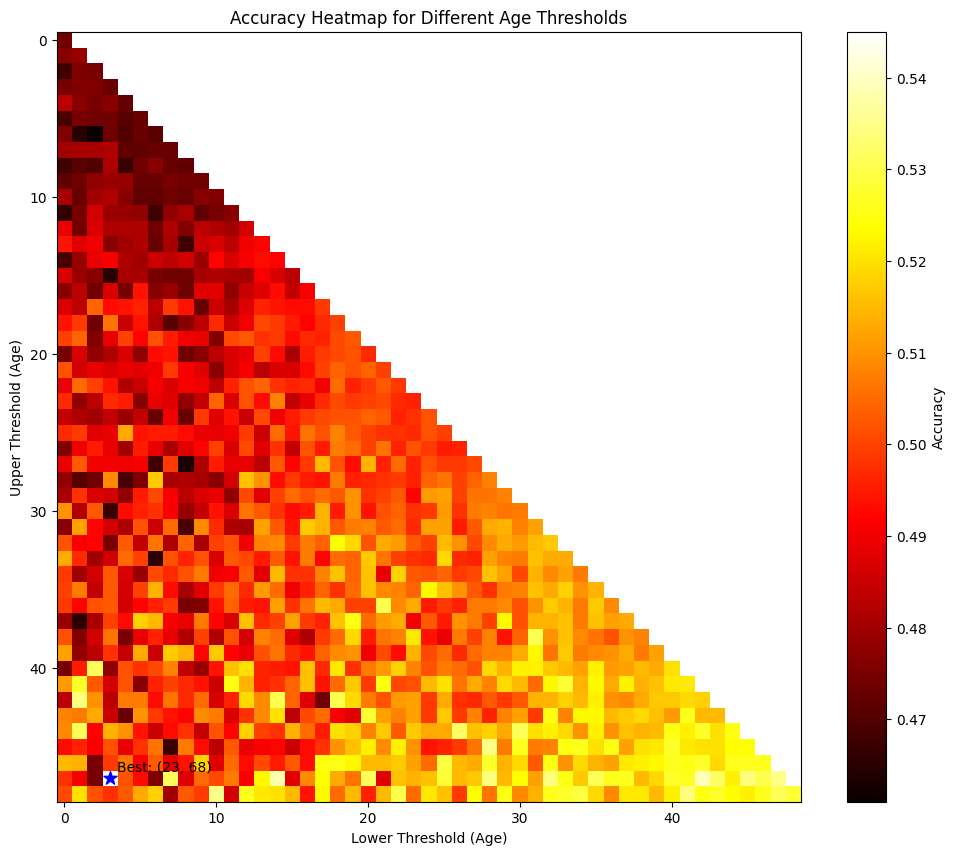

In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def predict_mets(ages, lower_threshold, upper_threshold):
    predictions = np.zeros_like(ages)
    predictions[ages <= lower_threshold] = 0  # Metsなし
    predictions[ages >= upper_threshold] = 1  # Metsあり
    middle_mask = (ages > lower_threshold) & (ages < upper_threshold)
    predictions[middle_mask] = np.random.randint(0, 2, size=np.sum(middle_mask))  # 無作為割り振り
    #predictions[middle_mask] = 0.5  # 中間のものは1/2とする

    return predictions

# 年齢の最小値と最大値
min_age, max_age = np.min(all_ages), np.max(all_ages)

# グリッドサーチのステップサイズ
step = 1

best_accuracy = 0
best_lower_threshold = 0
best_upper_threshold = 0

accuracies = []

# グリッドサーチ
for lower_threshold in range(int(min_age), int(max_age), step):
    for upper_threshold in range(lower_threshold + step, int(max_age) + step, step):
        predictions = predict_mets(all_ages, lower_threshold, upper_threshold)
        accuracy = accuracy_score(all_mets_binary, predictions)
        accuracies.append((lower_threshold, upper_threshold, accuracy))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lower_threshold = lower_threshold
            best_upper_threshold = upper_threshold

# 結果の表示
print(f"最適な下限閾値: {best_lower_threshold:.2f}歳")
print(f"最適な上限閾値: {best_upper_threshold:.2f}歳")
print(f"最高の正確度: {best_accuracy:.4f}")

# 最適な閾値での予測
best_predictions = predict_mets(all_ages, best_lower_threshold, best_upper_threshold)

# 混同行列の計算
tn, fp, fn, tp = np.bincount(2 * all_mets_binary + best_predictions, minlength=4)

# 感度、特異度の計算
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"感度: {sensitivity:.4f}")
print(f"特異度: {specificity:.4f}")

# ヒートマップの作成
df_accuracies = pd.DataFrame(accuracies, columns=['lower_threshold', 'upper_threshold', 'accuracy'])
pivot = df_accuracies.pivot(index='upper_threshold', columns='lower_threshold', values='accuracy')

plt.figure(figsize=(12, 10))
plt.imshow(pivot, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='Accuracy')
plt.title('Accuracy Heatmap for Different Age Thresholds')
plt.xlabel('Lower Threshold (Age)')
plt.ylabel('Upper Threshold (Age)')
plt.scatter(pivot.columns.get_loc(best_lower_threshold), pivot.index.get_loc(best_upper_threshold),
            color='blue', s=100, marker='*')
plt.annotate(f'Best: ({best_lower_threshold}, {best_upper_threshold})',
             (pivot.columns.get_loc(best_lower_threshold), pivot.index.get_loc(best_upper_threshold)),
             xytext=(5, 5), textcoords='offset points')
plt.show()


In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def predict_mets_with_nan(ages, lower_threshold, upper_threshold):
    """
    年齢に基づいてMetsの有無を予測します。
    - lower_threshold以下: 0 (Metsなし)
    - upper_threshold以上: 1 (Metsあり)
    - 閾値間: NaN (予測除外)

    Parameters:
    - ages: np.ndarray, 対象者の年齢データ
    - lower_threshold: int, 下限閾値
    - upper_threshold: int, 上限閾値

    Returns:
    - predictions: np.ndarray, 予測結果 (0, 1, NaN)
    """
    predictions = np.full_like(ages, np.nan, dtype=float)  # 初期値をNaNに設定
    predictions[ages <= lower_threshold] = 0  # Metsなし
    predictions[ages >= upper_threshold] = 1  # Metsあり
    return predictions

# 仮定: all_agesとall_mets_binaryは既に定義されているとします。
# 例:
# all_ages = np.array([...])
# all_mets_binary = np.array([...])

# 固定する閾値
fixed_lower_threshold = 35
fixed_upper_threshold = 58

# 予測の実行
fixed_predictions = predict_mets_with_nan(all_ages, fixed_lower_threshold, fixed_upper_threshold)

# NaNを除外するマスク
fixed_valid_mask = ~np.isnan(fixed_predictions)

# 有効な予測が存在するか確認
if np.sum(fixed_valid_mask) == 0:
    print("有効な予測が存在しません。")
else:
    # 正解率の計算
    fixed_accuracy = accuracy_score(all_mets_binary[fixed_valid_mask], fixed_predictions[fixed_valid_mask])

    # 混同行列の計算
    tn, fp, fn, tp = confusion_matrix(all_mets_binary[fixed_valid_mask], fixed_predictions[fixed_valid_mask]).ravel()

    # 感度、特異度の計算
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # 結果の表示
    print(f"固定された下限閾値: {fixed_lower_threshold}歳")
    print(f"固定された上限閾値: {fixed_upper_threshold}歳")
    print(f"正確度 (Accuracy): {fixed_accuracy:.4f}")
    print(f"感度 (Sensitivity): {sensitivity:.4f}")
    print(f"特異度 (Specificity): {specificity:.4f}")


固定された下限閾値: 35歳
固定された上限閾値: 58歳
正確度 (Accuracy): 0.4963
感度 (Sensitivity): 0.4319
特異度 (Specificity): 0.5556


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def predict_mets_with_nan(ages, lower_threshold, upper_threshold):
    """
    Predicts the presence of Mets based on age.
    - Below or equal to lower_threshold: 0 (Mets absent)
    - Above or equal to upper_threshold: 1 (Mets present)
    - Between thresholds: NaN (excluded from prediction)

    Parameters:
    - ages: np.ndarray, array of ages
    - lower_threshold: int, lower age threshold
    - upper_threshold: int, upper age threshold

    Returns:
    - predictions: np.ndarray, prediction results (0, 1, NaN)
    """
    predictions = np.full_like(ages, np.nan, dtype=float)  # Initialize with NaN
    predictions[ages <= lower_threshold] = 0  # Mets absent
    predictions[ages >= upper_threshold] = 1  # Mets present
    return predictions

# Assume all_ages and all_mets_binary are already defined
# Example:
# all_ages = np.array([...])
# all_mets_binary = np.array([...])

# Fixed thresholds
fixed_lower_threshold = 35
fixed_upper_threshold = 58

# Perform predictions
fixed_predictions = predict_mets_with_nan(all_ages, fixed_lower_threshold, fixed_upper_threshold)

# Create a mask to exclude NaN predictions
fixed_valid_mask = ~np.isnan(fixed_predictions)

# Check if there are valid predictions
if np.sum(fixed_valid_mask) == 0:
    print("No valid predictions exist.")
else:
    # Calculate accuracy
    fixed_accuracy = accuracy_score(all_mets_binary[fixed_valid_mask], fixed_predictions[fixed_valid_mask])

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(all_mets_binary[fixed_valid_mask], fixed_predictions[fixed_valid_mask]).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # Display results
    print(f"Fixed Lower Threshold: {fixed_lower_threshold} years")
    print(f"Fixed Upper Threshold: {fixed_upper_threshold} years")
    print(f"Accuracy: {fixed_accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    # Additional Visualization: Distribution for Age <=35

    # Create a mask for ages <=35
    age_threshold = 35
    mask_35 = all_ages <= age_threshold

    # Extract actual and predicted labels for age <=35
    actual_labels_35 = all_mets_binary[mask_35]
    predicted_labels_35 = fixed_predictions[mask_35]

    # Count the distribution of actual and predicted labels
    actual_counts_35 = pd.Series(actual_labels_35).value_counts().sort_index()
    predicted_counts_35 = pd.Series(predicted_labels_35).value_counts().sort_index()

    # Ensure both labels 0 and 1 are present
    for label in [0, 1]:
        if label not in actual_counts_35.index:
            actual_counts_35[label] = 0
        if label not in predicted_counts_35.index:
            predicted_counts_35[label] = 0

    # Sort the indices
    actual_counts_35 = actual_counts_35.sort_index()
    predicted_counts_35 = predicted_counts_35.sort_index()

    # Set up the bar graph
    labels = ['Mets Absent (0)', 'Mets Present (1)']
    x = np.arange(len(labels))  # Label positions
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot actual data
    rects1 = ax.bar(x - width/2, actual_counts_35.values, width, label='Actual Data', color='skyblue')

    # Plot predicted data
    rects2 = ax.bar(x + width/2, predicted_counts_35.values, width, label='Predicted Data', color='salmon')

    # Set labels and title in English
    ax.set_ylabel('Count')
    ax.set_xlabel('Presence of Mets')
    ax.set_title(f'Distribution of Actual and Predicted Mets for Age <= {age_threshold}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to add labels on top of the bars
    def autolabel(rects):
        """Attach a text label above each bar displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # Offset the text by 3 points vertically
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Apply the labeling function to both sets of bars
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()


In [50]:
import numpy as np
from sklearn.metrics import accuracy_score

# 年齢の範囲でグリッドサーチ
min_age, max_age = np.min(all_ages), np.max(all_ages)
step = 1
best_accuracy = 0
best_threshold = 0

for threshold in range(int(min_age), int(max_age) + 1, step):
    predictions = (all_ages >= threshold).astype(int)
    accuracy = accuracy_score(all_mets_binary, predictions)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"最適な閾値: {best_threshold}歳")
print(f"最高の正確度: {best_accuracy:.4f}")


最適な閾値: 42歳
最高の正確度: 0.6093


In [51]:
from sklearn.metrics import roc_curve

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(all_mets_binary, all_ages)

# Youden指数を計算
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f"Youden指数に基づく最適な閾値: {optimal_threshold:.2f}歳")

# 最適な閾値で予測
predictions = (all_ages >= optimal_threshold).astype(int)
accuracy = accuracy_score(all_mets_binary, predictions)
print(f"Accuracy at optimal threshold: {accuracy:.4f}")


Youden指数に基づく最適な閾値: 42.00歳
Accuracy at optimal threshold: 0.6093


最適な下限閾値: 41歳
最適な上限閾値: 45歳
最高の正確度: 0.6212
感度: 0.7870
特異度: 0.4569


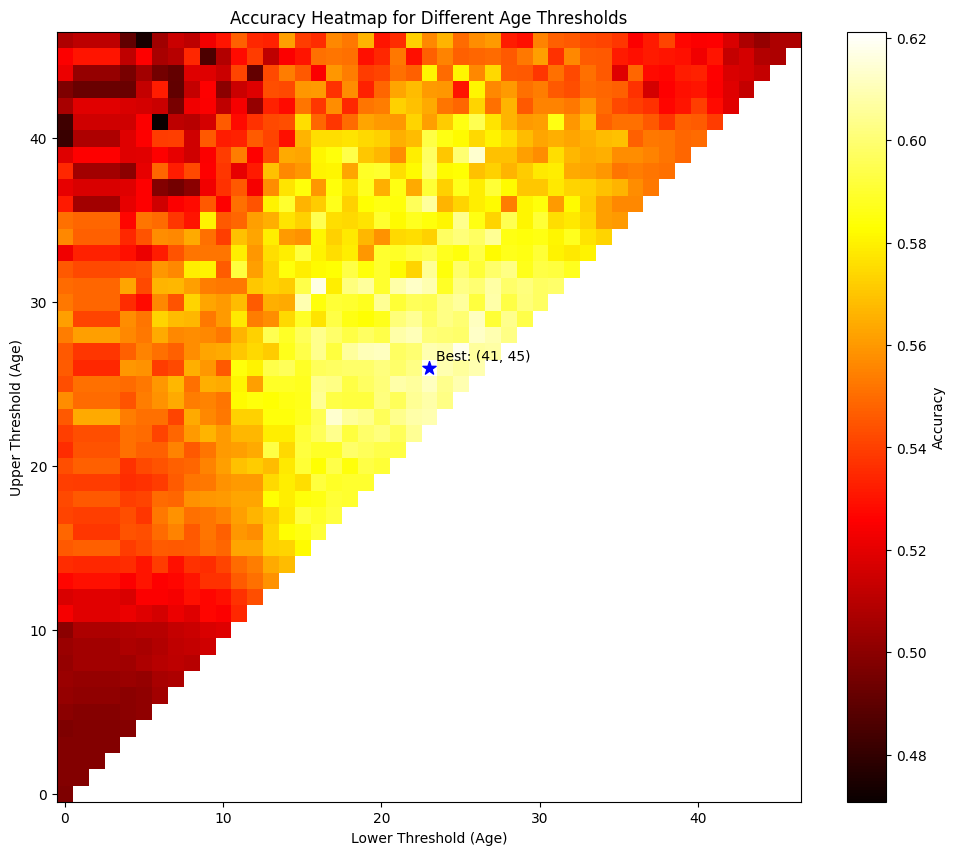

In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def predict_mets(ages, lower_threshold, upper_threshold):
    predictions = np.zeros_like(ages)
    predictions[ages <= lower_threshold] = 0  # Metsなし
    predictions[ages >= upper_threshold] = 1  # Metsあり

    middle_mask = (ages > lower_threshold) & (ages < upper_threshold)
    middle_indices = np.where(middle_mask)[0]
    num_middle = len(middle_indices)

    # 全体のMetsあり・なしの数
    total_mets = np.sum(all_mets_binary)
    total_no_mets = len(all_mets_binary) - total_mets

    # 既に予測したMetsあり・なしの数
    predicted_mets = np.sum(predictions == 1)
    predicted_no_mets = np.sum(predictions == 0)

    # 中間の年齢で予測すべきMetsあり・なしの数
    remaining_mets = total_mets - predicted_mets
    remaining_no_mets = total_no_mets - predicted_no_mets

    # 中間のデータ数に合わせて予測数を調整
    total_remaining = remaining_mets + remaining_no_mets
    if total_remaining > 0:
        mets_ratio = remaining_mets / total_remaining
        num_mets_in_middle = int(round(mets_ratio * num_middle))
    else:
        num_mets_in_middle = num_middle // 2  # 残りがない場合は半分ずつ

    num_mets_in_middle = min(num_mets_in_middle, num_middle)
    num_no_mets_in_middle = num_middle - num_mets_in_middle

    # 中間のデータに対して、残りのMetsあり・なしを割り振る
    np.random.seed(0)  # 再現性のため
    shuffled_indices = np.random.permutation(num_middle)
    mets_indices = middle_indices[shuffled_indices[:num_mets_in_middle]]
    no_mets_indices = middle_indices[shuffled_indices[num_mets_in_middle:]]

    predictions[mets_indices] = 1
    predictions[no_mets_indices] = 0

    return predictions

# 年齢の最小値と最大値
min_age, max_age = np.min(all_ages), np.max(all_ages)

# グリッドサーチのステップサイズ
step = 1

best_accuracy = 0
best_lower_threshold = 0
best_upper_threshold = 0

accuracies = []

# グリッドサーチ
for lower_threshold in range(int(min_age), int(max_age), step):
    for upper_threshold in range(lower_threshold + step, int(max_age) + step, step):
        predictions = predict_mets(all_ages, lower_threshold, upper_threshold)
        accuracy = accuracy_score(all_mets_binary, predictions)
        accuracies.append((lower_threshold, upper_threshold, accuracy))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lower_threshold = lower_threshold
            best_upper_threshold = upper_threshold

# 結果の表示
print(f"最適な下限閾値: {best_lower_threshold}歳")
print(f"最適な上限閾値: {best_upper_threshold}歳")
print(f"最高の正確度: {best_accuracy:.4f}")

# 最適な閾値での予測
best_predictions = predict_mets(all_ages, best_lower_threshold, best_upper_threshold)

# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(all_mets_binary, best_predictions).ravel()

# 感度、特異度の計算
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"感度: {sensitivity:.4f}")
print(f"特異度: {specificity:.4f}")

# ヒートマップの作成
df_accuracies = pd.DataFrame(accuracies, columns=['lower_threshold', 'upper_threshold', 'accuracy'])
pivot = df_accuracies.pivot(index='upper_threshold', columns='lower_threshold', values='accuracy')

plt.figure(figsize=(12, 10))
plt.imshow(pivot, cmap='hot', interpolation='nearest', aspect='auto', origin='lower')
plt.colorbar(label='Accuracy')
plt.title('Accuracy Heatmap for Different Age Thresholds')
plt.xlabel('Lower Threshold (Age)')
plt.ylabel('Upper Threshold (Age)')

# 最適な閾値をヒートマップ上に表示
plt.scatter(
    pivot.columns.get_loc(best_lower_threshold),
    pivot.index.get_loc(best_upper_threshold),
    color='blue', s=100, marker='*'
)
plt.annotate(
    f'Best: ({best_lower_threshold}, {best_upper_threshold})',
    (pivot.columns.get_loc(best_lower_threshold), pivot.index.get_loc(best_upper_threshold)),
    xytext=(5, 5), textcoords='offset points'
)
plt.show()


In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def predict_mets_with_nan(ages, lower_threshold, upper_threshold):
    """
    年齢に基づいてMetsの有無を予測します。
    - lower_threshold以下: 0 (Metsなし)
    - upper_threshold以上: 1 (Metsあり)
    - 閾値間: NaN (予測除外)

    Parameters:
    - ages: np.ndarray, 対象者の年齢データ
    - lower_threshold: int, 下限閾値
    - upper_threshold: int, 上限閾値

    Returns:
    - predictions: np.ndarray, 予測結果 (0, 1, NaN)
    """
    predictions = np.full_like(ages, np.nan, dtype=float)  # 初期値をNaNに設定
    predictions[ages <= lower_threshold] = 0  # Metsなし
    predictions[ages >= upper_threshold] = 1  # Metsあり
    return predictions

# 仮定: all_agesとall_mets_binaryは既に定義されているとします。
# 例:
# all_ages = np.array([...])
# all_mets_binary = np.array([...])

# 年齢の最小値と最大値
min_age, max_age = np.min(all_ages), np.max(all_ages)

# グリッドサーチのステップサイズ
step = 1

best_accuracy = 0
best_lower_threshold = 0
best_upper_threshold = 0

accuracies = []

# グリッドサーチ
for lower_threshold in range(int(min_age), int(max_age), step):
    for upper_threshold in range(lower_threshold + step, int(max_age) + step, step):
        predictions = predict_mets_with_nan(all_ages, lower_threshold, upper_threshold)
        # NaNを除外するためのマスク
        valid_mask = ~np.isnan(predictions)

        # 有効な予測が存在する場合のみ評価
        if np.sum(valid_mask) == 0:
            continue  # 有効なデータがない場合はスキップ

        # 正解率の計算
        accuracy = accuracy_score(all_mets_binary[valid_mask], predictions[valid_mask])
        accuracies.append((lower_threshold, upper_threshold, accuracy))

        # 最高の正確度を更新
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lower_threshold = lower_threshold
            best_upper_threshold = upper_threshold

        print(lower_threshold, upper_threshold, len(predictions[valid_mask]), accuracy)


# 結果の表示
print(f"最適な下限閾値: {best_lower_threshold}歳")
print(f"最適な上限閾値: {best_upper_threshold}歳")
print(f"最高の正確度: {best_accuracy:.4f}")

# 最適な閾値での予測
best_predictions = predict_mets_with_nan(all_ages, best_lower_threshold, best_upper_threshold)

# NaNを除外するマスク
best_valid_mask = ~np.isnan(best_predictions)

# 混同行列の計算
if np.sum(best_valid_mask) > 0:
    tn, fp, fn, tp = confusion_matrix(all_mets_binary[best_valid_mask], best_predictions[best_valid_mask]).ravel()

    # 感度、特異度の計算
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    print(f"感度 (Sensitivity): {sensitivity:.4f}")
    print(f"特異度 (Specificity): {specificity:.4f}")
else:
    print("有効な予測が存在しないため、混同行列と感度・特異度を計算できません。")

# ヒートマップの作成
df_accuracies = pd.DataFrame(accuracies, columns=['lower_threshold', 'upper_threshold', 'accuracy'])
pivot = df_accuracies.pivot(index='upper_threshold', columns='lower_threshold', values='accuracy')

plt.figure(figsize=(12, 10))
cax = plt.imshow(pivot, cmap='hot', interpolation='nearest', aspect='auto', origin='lower')
plt.colorbar(cax, label='Accuracy')
plt.title('Accuracy Heatmap for Different Age Thresholds')
plt.xlabel('Lower Threshold (Age)')
plt.ylabel('Upper Threshold (Age)')

# 最適な閾値をヒートマップ上に表示
# 閾値が存在する範囲内でのインデックス取得
if best_lower_threshold in pivot.columns and best_upper_threshold in pivot.index:
    lower_idx = list(pivot.columns).index(best_lower_threshold)
    upper_idx = list(pivot.index).index(best_upper_threshold)
    plt.scatter(lower_idx, upper_idx, color='blue', s=100, marker='*', label='Best Threshold')
    plt.annotate(
        f'Best: ({best_lower_threshold}, {best_upper_threshold})',
        (lower_idx, upper_idx),
        xytext=(5, 5), textcoords='offset points',
        color='blue'
    )
    plt.legend()

plt.show()


20 21 1000 0.474
20 22 979 0.4759959141981614
20 23 957 0.47335423197492166
20 24 941 0.4718384697130712
20 25 918 0.47058823529411764
20 26 901 0.47058823529411764
20 27 887 0.4689966178128523
20 28 865 0.46936416184971097
20 29 848 0.4681603773584906
20 30 832 0.46875
20 31 816 0.4693627450980392
20 32 795 0.4691823899371069
20 33 778 0.47429305912596403
20 34 760 0.4776315789473684
20 35 744 0.4771505376344086
20 36 723 0.4702627939142462
20 37 701 0.47503566333808844
20 38 685 0.4802919708029197
20 39 666 0.4804804804804805
20 40 651 0.4823348694316436
20 41 633 0.47709320695102686
20 42 612 0.47875816993464054
20 43 589 0.4770797962648557
20 44 566 0.4734982332155477
20 45 542 0.477859778597786
20 46 512 0.474609375
20 47 496 0.46975806451612906
20 48 467 0.4732334047109208
20 49 448 0.4799107142857143
20 50 430 0.4790697674418605
20 51 417 0.47721822541966424
20 52 392 0.48214285714285715
20 53 365 0.4876712328767123
20 54 347 0.4812680115273775
20 55 319 0.4702194357366771
20 56

KeyboardInterrupt: 

### 学習がうまくいかないことに対する対応版

##**Finetune other classification model**

```
分ける基準
Age: <45: 1901, >=58: 929 --> age estimation modelが完成済
AC: <85: 1555, >=95: 1410
SBP: <125: 1429, >=140: 1374
DBP: <80: 2055, >=85: 2111
HDLC: <45: 1349, >60: 1496
TG: <100: 1608, >=200: 1414
#BS: <75: 204, >=130: 398 --> 眼底で分別
```

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset from your specified path
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'
data = pd.read_csv(file_path)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create new columns to classify the data based on the provided thresholds
data['AC_class'] = data['AC'].apply(lambda x: 'low' if x < 85 else 'high' if x >= 95 else 'mid')
data['SBP_class'] = data['SBP'].apply(lambda x: 'low' if x < 125 else 'high' if x >= 140 else 'mid')
data['DBP_class'] = data['DBP'].apply(lambda x: 'low' if x < 80 else 'high' if x >= 85 else 'mid')
data['HDLC_class'] = data['HDLC'].apply(lambda x: 'low' if x < 45 else 'high' if x > 60 else 'mid')
data['TG_class'] = data['TG'].apply(lambda x: 'low' if x < 100 else 'high' if x >= 200 else 'mid')


data[['filename', 'AC_class', 'SBP_class', 'DBP_class', 'HDLC_class', 'TG_class']].head()
